<a href="https://colab.research.google.com/github/matibag1714977/LabiagiProject/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto-Scene Classification**

#Import vari

In [10]:
import numpy as np      #to perform mathematical operations on arrays and matrices
import matplotlib.pyplot as plt  #to visualize images and plot graphs

#provides algoithms and tools for data analysis and modeling(classification,regression,clustering)
from sklearn.model_selection import train_test_split        
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#It provides a user-friendly interface for building and training deep learning models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import keras

# It provides various tools and functions for image and video processing, including image filtering, feature detection, and object tracking.
import cv2
import imghdr
import os

import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf





#Import dataset Prova

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

folder_id = '1pFM_HpOjh0qbAadk0-1Fz89mwLHrnQHB?usp=share_link'
data_path = '/content/gdrive/MyDrive/Dataset/input_data'


# mount the folder
drive.mount('/content/gdrive', force_remount=True)




Mounted at /content/gdrive
Mounted at /content/gdrive


#Dividere tramite Pytorch

In [ ]:
import os
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# Definisci la trasformazione delle immagini
transform = transforms.Compose(
    [transforms.Resize((224, 224)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

input_path='/content/gdrive/MyDrive/Dataset/input_data'
# Trasforma il dataset
dataset = datasets.ImageFolder(input_path, transform=transform)

print(dataset)

# Definisci le proporzioni di training, validation e test set
train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

b_size=5

# Calcola le lunghezze dei subset
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Dividi il dataset in training, validation e test set
train_data, test_data, val_data = data.random_split(dataset, [train_size, test_size, val_size])

train_loader=data.DataLoader(train_data,batch_size=b_size, shuffle=True, num_workers=2)
validation_loader=data.DataLoader(val_data,batch_size=b_size, shuffle=False,  num_workers=2)
test_loader=data.DataLoader(test_data,batch_size=b_size,shuffle=False, num_workers=2)

print(len(train_data))
print(len(val_data))
print(len(test_data))

classes = ('airport_terminal', 'beach', 'bridge', 'forest',
           'mountain', 'playground', 'river', 'skyscraper', 'street', 'temple')





#stampa prova

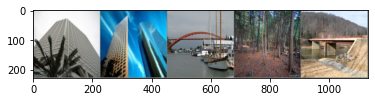

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(b_size)))

#Carico resnet50

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load ResNet50 model
resnet50 = models.resnet50(weights=None)




# Prova uso gpu

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("Using CPU")
print(device)

# Resnet che corre su device
resnet50.to(device)

# Loss e optimizer

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# Train

Inizializzo le liste per raccogliere dati

In [16]:
loss_values = []  # lista vuota per raccogliere i valori della loss function
val_loss_values = []

Definisco validation

In [19]:
def validate(model, criterion, validation_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(validation_loader)

Training

In [ ]:
num_epochs=20

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data

        #mandare inputs e a ogni passo alla gpu
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistica
        running_loss += loss.item()
        if i % 200 == 199:
            # aggiungi il valore della loss alla lista
            loss_values.append(running_loss / 200)
            val_loss = validate(resnet50, criterion, validation_loader)
            val_loss_values.append(val_loss)
            print(f'[{epoch + 1},{i + 1:4d}] loss: {running_loss / 200:.3f} val_loss:{val_loss}')
            running_loss = 0.0
        
print('Finished Training')

# Salvo dati

In [21]:
np.save('/content/gdrive/MyDrive/Dataset/loss_SGD_lr001.npy', loss_values)
np.save('/content/gdrive/MyDrive/Dataset/val_SGD_lr001.npy', val_loss_values)

# Carico dati

In [19]:
loss_values = np.load('/content/gdrive/MyDrive/Dataset/loss_SGD_lr001.npy')


# Stampo loss function

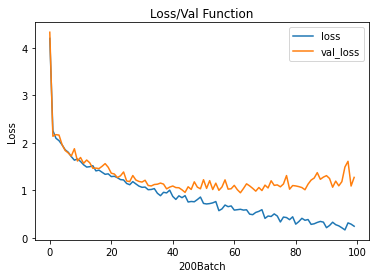

In [25]:
# creo grafico lineare
plt.plot(loss_values)
plt.plot(val_loss_values)

# titolo e assi
plt.title('Loss/Val Function')
plt.xlabel('200Batch')
plt.ylabel('Loss')

plt.legend(['loss','val_loss'],loc='upper right')

plt.show()

# Salvo il modello dopo il training

In [24]:
PATH = '/content/gdrive/MyDrive/Dataset/resnet50lr001.pth'
torch.save(resnet50.state_dict(), PATH)

# Carico modello salvato precedentemente

In [ ]:
resnet50 = models.resnet50(pretrained=False)
PATH = '/content/gdrive/MyDrive/Dataset/resnet50.pth'
# Carico i pesi salvati precedentemente
resnet50.load_state_dict(torch.load(PATH))
resnet50.to(device)

# Uso modello su test

In [ ]:

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
accuracy = 100 * correct / total
print('Accuracy of the model on the test images: {:.2f}%'.format(accuracy))

Accuracy of the model on the test images: 74.32%


#Classi peggiori e migliori

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
       # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet50(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airport_terminal is 78.0 %
Accuracy for class: beach is 70.0 %
Accuracy for class: bridge is 62.5 %
Accuracy for class: forest is 80.9 %
Accuracy for class: mountain is 80.7 %
Accuracy for class: playground is 83.7 %
Accuracy for class: river is 26.3 %
Accuracy for class: skyscraper is 85.0 %
Accuracy for class: street is 71.8 %
Accuracy for class: temple is 41.7 %


# Test con immagini

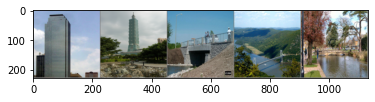

GroundTruth:  skyscraper skyscraper bridge bridge


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
images = images.to(device)
outputs = resnet50(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  skyscraper mountain playground mountain
